In [1]:
import numpy as np
from scipy.signal import fftconvolve
from collections import deque

import matplotlib.pyplot as plt

from numpy.polynomial.polynomial import polyval2d
from numpy.polynomial.chebyshev import chebval2d
from scipy.stats import multivariate_normal

from sklearn import linear_model
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from patsy import dmatrix
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

In [2]:
def display_images(template, science, difference, title):
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    title_ls = ['template', 'science', 'diff']
    ax[0].imshow(interval(template), cmap='gray', origin='lower')
    ax[1].imshow(interval(science), cmap='gray', origin='lower')
    ax[2].imshow(interval(difference), cmap='gray', origin='lower')
    for i in range(3): ax[i].set_axis_off() 
    for i in range(3): ax[i].set_title(title_ls[i])
    plt.suptitle(title, y=0.65)
    
def compute_xy_grids(x_len, y_len):
    x = np.arange(- x_len // 2 + 1, x_len // 2 + 1, 1)
    y = np.arange(- y_len // 2 + 1, y_len // 2 + 1, 1)
    xx, yy = np.meshgrid(x, y)
    return xx, yy
    

def Gaussian2d(xx, yy, m=[0., 0.], cov=[[1, 0], [0, 1]]):
    grid = np.dstack((xx, yy))
    var = multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

##################
# simulate images
def sim_spatially_varying_sigma(x, y, sigma, T=20, alpha=0.1):
    sigma_x = sigma + alpha * np.sin(2 * np.pi / T * x) * sigma
    sigma_y = sigma + alpha * np.sin(2 * np.pi / T * y) * sigma
    return sigma_x, sigma_y


def sim_source_catalog(n_sources, x_lim, y_lim, min_flux, max_flux, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    x_pos = np.random.uniform(x_lim[0], x_lim[1], n_sources)
    y_pos = np.random.uniform(y_lim[0], y_lim[1], n_sources)  
    fluxes = np.random.uniform(min_flux, max_flux, n_sources)
    source_catalog = {'x_pos': x_pos, 'y_pos': y_pos, 'fluxes': fluxes}
    return source_catalog

def sim_image(image_size, sky_sig, psf_sig, source_catalog, T=20, alpha=0.1):
    image_xx, image_yy = compute_xy_grids(image_size, image_size)
    image_grid = np.dstack((image_xx, image_yy))
    image =  np.random.normal(scale=sky_sig, size=(image_size, image_size))
    # add background sources
    fluxes = source_catalog['fluxes']
    x_pos, y_pos = source_catalog['x_pos'], source_catalog['y_pos']

    for i in range(len(fluxes)):
        x, y = x_pos[i], y_pos[i]
        sigma_x, sigma_y = sim_spatially_varying_sigma(x, y, psf_sig, T=T, alpha=alpha)
        image += fluxes[i] * Gaussian2d(
            image_xx, image_yy, m=[x, y], cov=[[sigma_x, 0], [0, sigma_y]]
        )
    return image
#################################################

    
def ChebyshevGaussian2d(xx, yy, gauss_cov, poly_deg):
    # compute Gaussian
    gau = Gaussian2d(xx, yy, cov=gauss_cov)
    # compute Chebyshev
    x_deg, y_deg = poly_deg[0], poly_deg[1]
    coef_x = np.zeros(x_deg + 1)
    coef_x[x_deg] = 1
    coef_y = np.zeros(y_deg + 1)
    coef_y[y_deg] = 1
    coefs = np.outer(coef_x, coef_y)
    cheb = chebval2d(xx, yy, c=coefs)
    return cheb * gau

def normalize_bases(bases):
    b0 = None
    normalized_bases = deque()
    for b in bases:
        kernel_sum = b.sum()
        if kernel_sum > 1e-9:
            basis = b / kernel_sum
            if b0 is None:
                b0 = basis
                continue
            else:
                basis -= b0
        else:
            basis = b
        normalized_bases.append(basis)
    normalized_bases.appendleft(b0)
    return list(normalized_bases)
    
def ChebyshevGaussianBases(kernel_size=31, gaussian_sigmas=[0.75, 1.5, 3.0], poly_degrees= [4, 2, 2]):
    xx, yy = compute_xy_grids(kernel_size, kernel_size)
    kernel_bases = []
    for id_x, x_sig in enumerate(gaussian_sigmas):
        for id_y, y_sig in enumerate(gaussian_sigmas):
            for x_deg in range(poly_degrees[id_x]+1):
                for y_deg in range(poly_degrees[id_y]+1):
                    gauss_cov = [[x_sig, 0.], [0., y_sig]]
                    poly_deg = (x_deg, y_deg)
                    kernel_basis = ChebyshevGaussian2d(xx, yy, gauss_cov, poly_deg)
                    kernel_bases.append(kernel_basis)
    return kernel_bases

def DeltaBases(kernel_size=11):
    kernel_bases = []
    for i in range(kernel_size):
        for j in range(kernel_size):
            basis = np.zeros((kernel_size, kernel_size))
            basis[i][j] = 1
            kernel_bases.append(basis)
    return kernel_bases

def PolyModel(x_size, y_size, degree):
    xx, yy = compute_xy_grids(x_size, y_size)
    xx, yy = xx / x_size, yy / y_size
    spatial_images = []
    for current_deg in range(0, degree + 1):
        for x_deg in range(current_deg + 1):
            y_deg = current_deg - x_deg 
            coef_x = np.zeros(x_deg + 1)
            coef_x[x_deg] = 1
            coef_y = np.zeros(y_deg + 1)
            coef_y[y_deg] = 1
            coefs = np.outer(coef_x, coef_y)
            spatial_image = polyval2d(xx, yy, c=coefs)
            spatial_images.append(spatial_image)
    spatial_images
    return spatial_images

def BsplinesModel(x_size, y_size, dof):
    dof = 3
    xx, yy = compute_xy_grids(x_size, y_size)
    bsplines = dmatrix("te(cr(xx, dof), cc(yy, dof)) - 1", {"xx": xx.ravel(), "yy": yy.ravel(), "dof": dof})
    kernel_bases = []
    for i in range(bsplines.shape[1]):
        basis = bsplines[:, i]
        kernel_bases.append(basis.reshape(y_size, x_size))
    return kernel_bases

def _compute_base_vecs(template, kernel_bases):
    base_vecs = []
    for basis in kernel_bases:
        base_im = fftconvolve(template, basis, mode='same')
        base_vecs.append(base_im.flatten())
    base_vecs = np.vstack(base_vecs).T   
    return base_vecs
"""
def _compute_base_spatial_vecs(base_vecs, spatial_images, constant_scaling=True):
    base_spatial_vecs = []
    for i in range(base_vecs.shape[1]):
        base_vec = base_vecs[:, i]
        if constant_scaling and i == 0:
            base_spatial_vecs.append(base_vec)
            continue
        for j in range(len(spatial_images)):
            spatial_vec =  spatial_images[j].flatten()
            base_spatial_vec = base_vec * spatial_vec
            base_spatial_vecs.append(base_spatial_vec)
    base_spatial_vecs = np.vstack(base_spatial_vecs).T
    return base_spatial_vecs
"""

def _compute_base_spatial_vecs(base_vecs, spatial_images, constant_scaling=True):
    base_spatial_vecs = []
    for j in range(len(spatial_images)):
        spatial_vec = spatial_images[j].flatten()
        for i in range(base_vecs.shape[1]):
            base_vec = base_vecs[:, i]
            base_spatial_vec = base_vec * spatial_vec
            base_spatial_vecs.append(base_spatial_vec)
    base_spatial_vecs = np.vstack(base_spatial_vecs).T
    return base_spatial_vecs    

def AlardLuptonAlgorithm(template, science, kernel_bases, spatial_model, bg_model, regressor, constant_scaling=True):
    if constant_scaling:
        kernel_bases = normalize_bases(kernel_bases)
        print('kernel bases normalized')
    base_vecs = _compute_base_vecs(template, kernel_bases)
    base_spatial_vecs = _compute_base_spatial_vecs(base_vecs, spatial_model, constant_scaling=constant_scaling)
    bg_vecs = np.vstack([bg.flatten() for bg in bg_model]).T
    X = np.concatenate((base_spatial_vecs, bg_vecs), axis=1)
    y = science.flatten()
    y_pred = regressor.fit(X, y)
    y_pred = regressor.predict(X)
    difference = science - y_pred.reshape(template.shape)
    return difference, regressor, X, y 

In [3]:
image_size = 255
period = image_size * 2
# simulate source catalog
n_background_sources = 50
# image size
edge_offset = 10
x_lim = (- image_size//2 + 1 + edge_offset, image_size//2 + 1 - edge_offset)
y_lim = (- image_size//2 + 1 + edge_offset, image_size//2 + 1 - edge_offset)
# fluxes
min_flux, max_flux = 20000, 50000
# background source
background_src_cat = sim_source_catalog(
    n_background_sources, x_lim,  y_lim, min_flux, max_flux, random_seed=1
)
# image sigma
tmpl_sky_sig, sci_sky_sig = 0.2, 0.2
tmpl_psf_sig, sci_psf_sig = 1.6, 2.2
# simulate images
template = sim_image(image_size, tmpl_sky_sig, tmpl_psf_sig, background_src_cat, T=period, alpha=0)
science = sim_image(image_size, sci_sky_sig, sci_psf_sig, background_src_cat, T=period, alpha=0.01)

kernel bases normalized


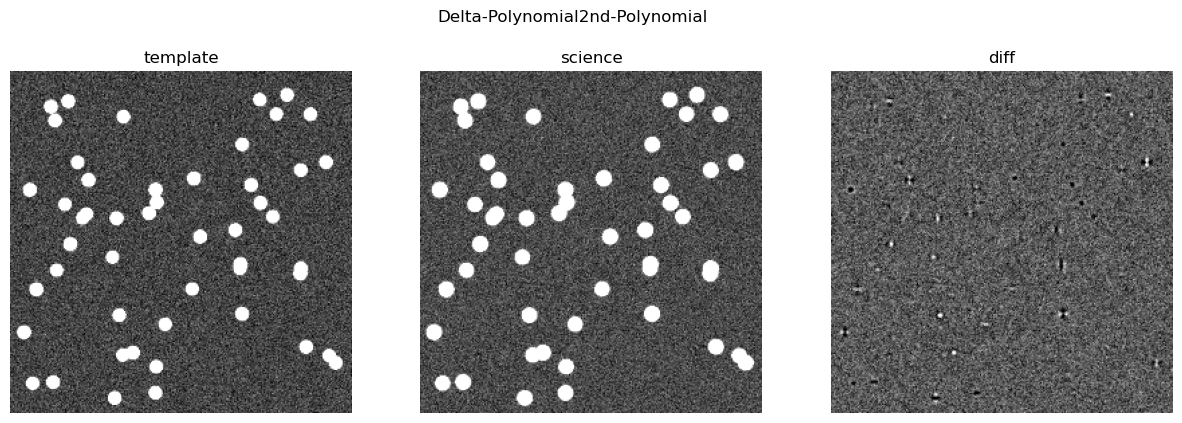

In [120]:
difference, regressor, X, y = AlardLuptonAlgorithm(
    template = template,
    science = science, 
    kernel_bases = DeltaBases(kernel_size=11),
    spatial_model = PolyModel(x_size=template.shape[1], y_size=template.shape[0], degree=2), 
    bg_model = PolyModel(x_size=template.shape[1], y_size=template.shape[0], degree=1), 
    regressor=linear_model.LinearRegression(fit_intercept=False))
display_images(template=template, science=science, difference=difference, title='Delta-Polynomial2nd-Polynomial')

kernel bases normalized


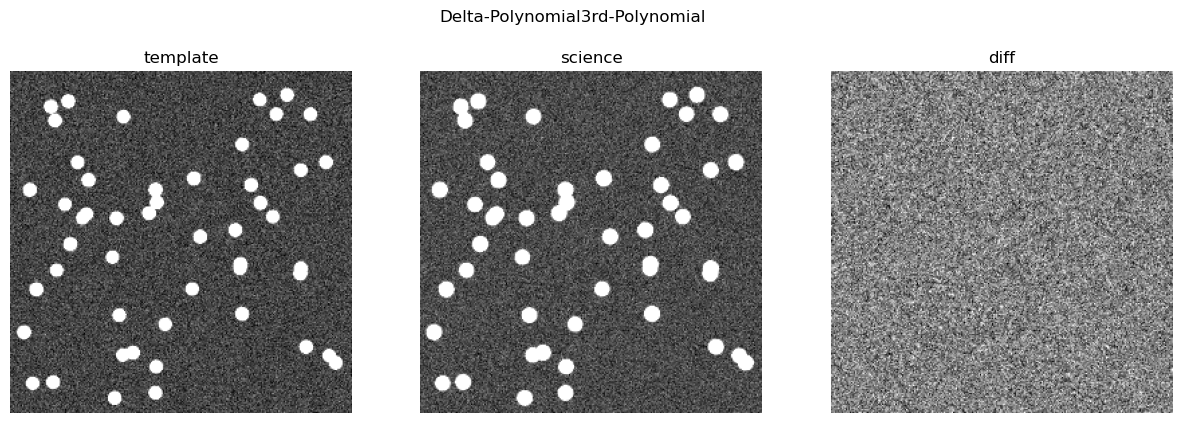

In [119]:
difference, regressor, X, y = AlardLuptonAlgorithm(
    template = template,
    science = science, 
    kernel_bases = DeltaBases(kernel_size=11),
    spatial_model = PolyModel(x_size=template.shape[1], y_size=template.shape[0], degree=3), 
    bg_model = PolyModel(x_size=template.shape[1], y_size=template.shape[0], degree=1), 
    regressor=linear_model.LinearRegression(fit_intercept=False))
display_images(template=template, science=science, difference=difference, title='Delta-Polynomial3rd-Polynomial')

kernel bases normalized


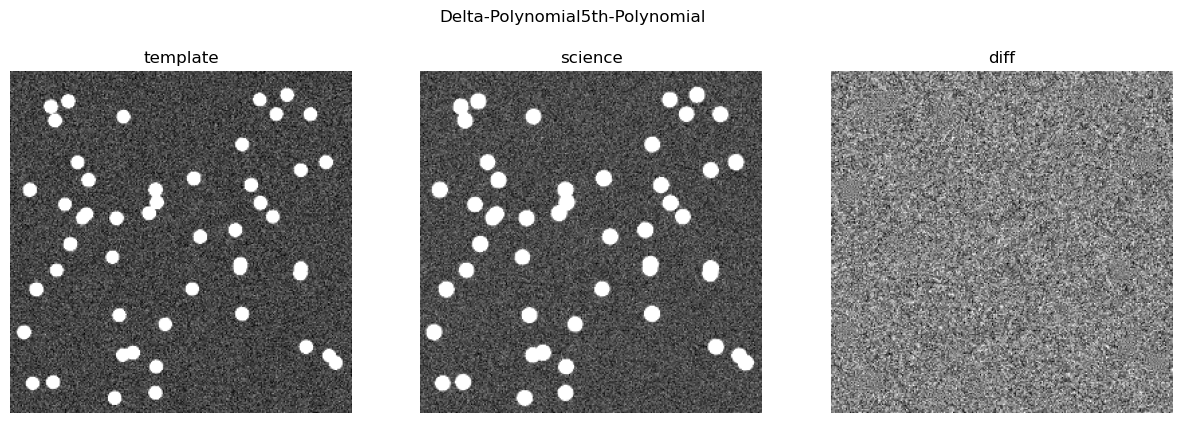

In [4]:
difference, regressor, X, y = AlardLuptonAlgorithm(
    template = template,
    science = science, 
    kernel_bases = DeltaBases(kernel_size=11),
    spatial_model = PolyModel(x_size=template.shape[1], y_size=template.shape[0], degree=5), 
    bg_model = PolyModel(x_size=template.shape[1], y_size=template.shape[0], degree=1), 
    regressor=linear_model.LinearRegression(fit_intercept=False))
display_images(template=template, science=science, difference=difference, title='Delta-Polynomial5th-Polynomial')

kernel bases normalized
kernel bases normalized
kernel bases normalized
kernel bases normalized
kernel bases normalized
kernel bases normalized
kernel bases normalized
kernel bases normalized
kernel bases normalized


Text(0.5, 0.95, 'L2 Regularization')

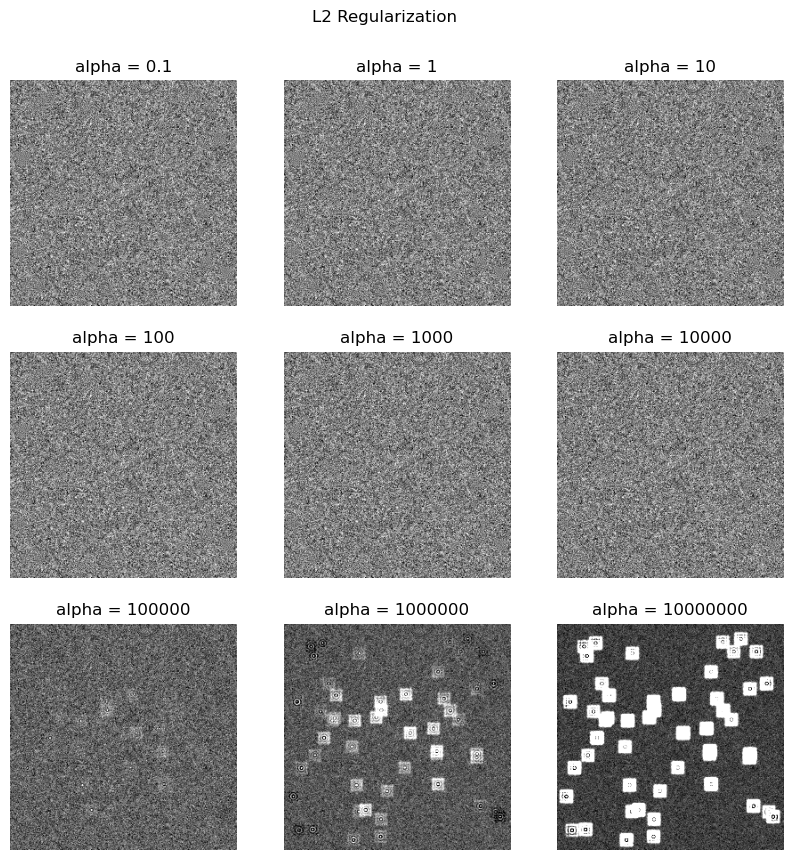

In [19]:
alphas = [0.1, 1, 10, 100, 1000, 10000, 100_000, 100_000_0, 100_000_00]
fig, ax = plt.subplots(3, 3, figsize=(10,10))
ax_ls = ax.flat
for i in range(9):
    alpha = alphas[i]
    difference, regressor, X, y = AlardLuptonAlgorithm(
        template = template,
        science = science, 
        kernel_bases = DeltaBases(kernel_size=11),
        spatial_model = PolyModel(x_size=template.shape[1], y_size=template.shape[0], degree=5), 
        bg_model = PolyModel(x_size=template.shape[1], y_size=template.shape[0], degree=1), 
        regressor=linear_model.Ridge(alpha=alpha, fit_intercept=False))
    ax_ls[i].imshow(interval(difference), cmap='gray', origin='lower')
    ax_ls[i].set_axis_off() 
    ax_ls[i].set_title(f'alpha = {alpha}')
plt.suptitle('L2 Regularization', y=0.95)

# Feature selection

\begin{equation}
    \tilde{S}(x, y) = [\kappa \otimes T](x, y).
\end{equation}

\begin{equation}
D = S - \tilde{S}.
\end{equation}

\begin{equation}
    \kappa(u, v, x, y) = \sum_{q=1}^{N_{\kappa}} a_q(x, y)\kappa_q(u, v).
\end{equation}

\begin{equation}
    a_q(x, y) = \sum_{\substack{0\le m\le d_q,\\0\le n\le d_q-m}} a_{qmn}x^my^n.
\end{equation}

\begin{equation}
    \tilde{S}(x,y) = \sum_q^{N_{\kappa}} \sum_{\substack{0\le m\le d_q,\\0\le n\le d_q-m}} a_{qmn}x^my^n [\kappa_q \otimes T](x,y). 
\end{equation}

map (q, m, n) to a new index i, define 2D image $x^my^n [\kappa_q \otimes T](x,y)$ as $W_i$, we have

\begin{equation}
    \tilde{S}(x,y) = \sum_i  a_{i}W_i(x,y). 
\end{equation}

Expand W_i to a 1D column vector $\vec{x_i}$, $\tilde{S}$ to a 1D column vector $\vec{\tilde{y}}$, we have the matrix expression

\begin{equation}
    \vec{\tilde{y}} = \begin{bmatrix}
        | & | & | \\
        \vec{W_1} & \ldots & \vec{W_n} \\
        | & | & |
    \end{bmatrix} 
\times
\begin{bmatrix}
    a_1 \\ 
    \ldots \\ 
    a_n
\end{bmatrix}
\end{equation}

This is a linear regression problem with $n$ features. $n$ equals the number of fitting parameters

In [6]:
from scipy.stats import spearmanr
spearman_corr = []
for i in range(X.shape[1]):
    spearman_corr.append(spearmanr(X[:, i], y).correlation)
spearman_corr = np.array(spearman_corr)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Text(0.5, 0.95, 'Spearman Correlation')

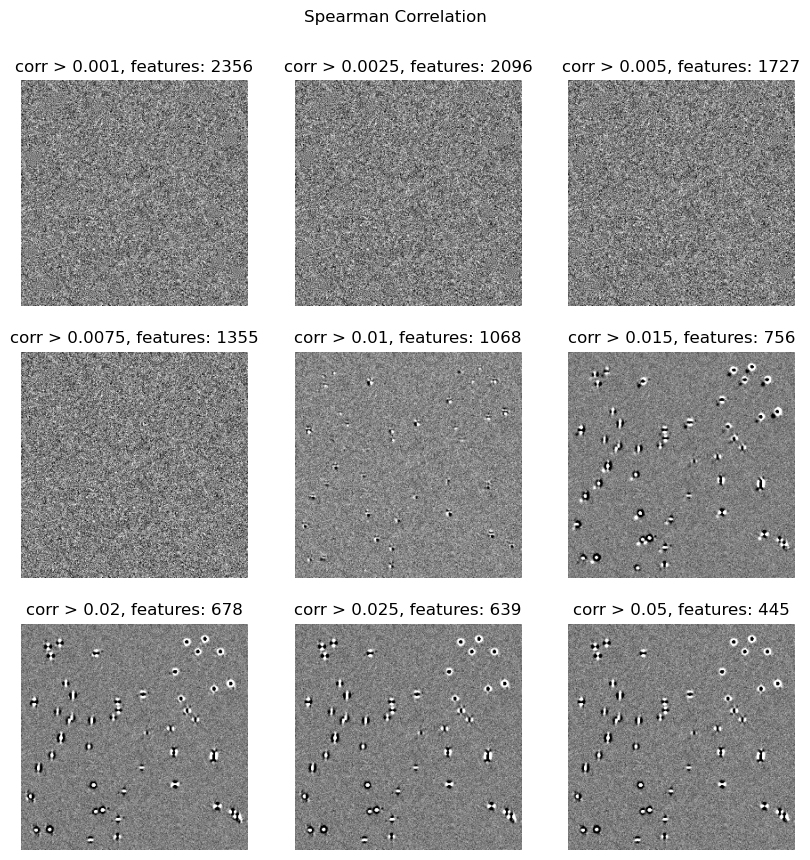

In [7]:
threshold = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.015, 0.02, 0.025, 0.05]

fig, ax = plt.subplots(3, 3, figsize=(10,10))
ax_ls = ax.flat
for i in range(9):
    t = threshold[i]
    idx = np.abs(spearman_corr) > t
    X_selected = X[:, idx]
    lin = linear_model.LinearRegression(fit_intercept=True)
    lin.fit(X_selected, y)
    y_pred = lin.predict(X_selected)
    difference = science - y_pred.reshape(template.shape)
    ax_ls[i].imshow(interval(difference), cmap='gray', origin='lower')
    ax_ls[i].set_axis_off() 
    ax_ls[i].set_title(f'corr > {t}, features: {idx.sum()}')
plt.suptitle('Spearman Correlation', y=0.95)

# fit kernel with high spatial order is slow, strong regularization may cause underfitting

# keep all $W_i$ from lower spatial order (1 is enough for dc2), using feature selection tools to select $W_i$ from higher spatial order, we can set a maximum number of kernel bases or set a selection threshold to control the model complexity

# split base images

In [11]:
preserved_deg = 3
preserved_idx = len(PolyModel(x_size=template.shape[1], y_size=template.shape[0], degree=preserved_deg)) * len(DeltaBases(kernel_size=11))

In [12]:
preserved_idx

1210

In [13]:
preserved_X = X[:, 0: preserved_idx]
remaining_X = X[:, preserved_idx:]

# Mutual Information 

In [117]:
mi = mutual_info_regression(remaining_X, y)

Text(0.5, 0.95, 'Mutual Information')

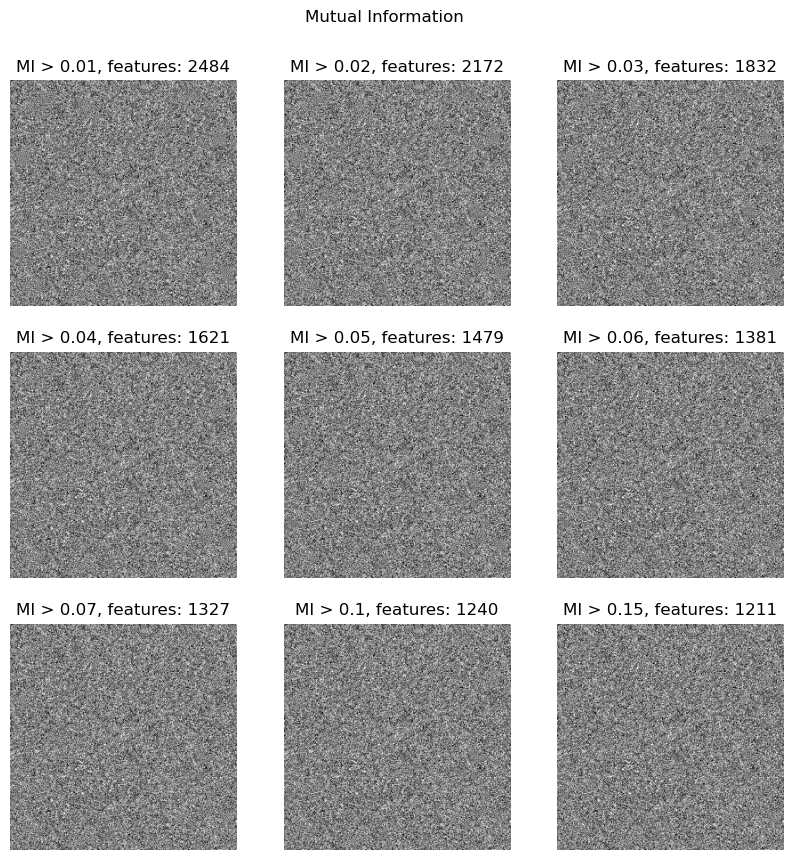

In [118]:
threshold = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.1, 0.15]
fig, ax = plt.subplots(3, 3, figsize=(10,10))
ax_ls = ax.flat
for i in range(9):
    t = threshold[i]
    idx = mi > t
    selected_X = remaining_X[:, idx]
    X_new = np.concatenate((preserved_X, selected_X), axis=1)
    lin = linear_model.LinearRegression(fit_intercept=True)
    lin.fit(X_new, y)
    y_pred = lin.predict(X_new)
    difference = science - y_pred.reshape(template.shape)
    ax_ls[i].imshow(interval(difference), cmap='gray', origin='lower')
    ax_ls[i].set_axis_off() 
    ax_ls[i].set_title(f'MI > {t}, features: {X_new.shape[1]}')
plt.suptitle('Mutual Information', y=0.95)

# Linear Correlation

In [14]:
from scipy.stats import pearsonr

In [15]:
pearson_corr = []
for i in range(remaining_X.shape[1]):
    pearson_corr.append(pearsonr(remaining_X[:, i], y)[0])
pearson_corr = np.array(pearson_corr)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, 0.95, 'Pearson Correlation')

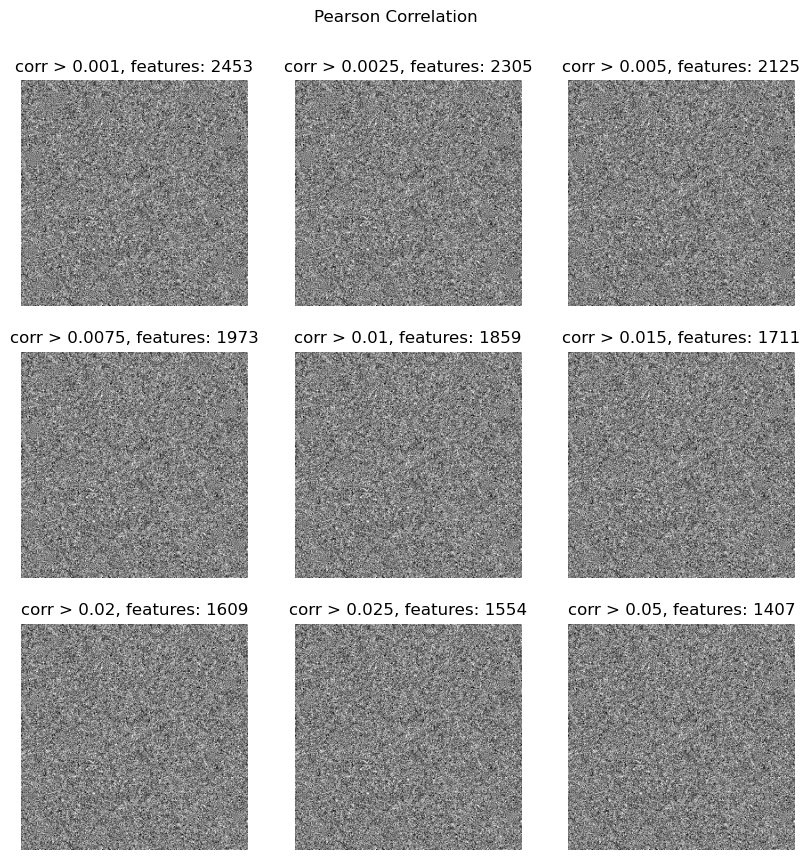

In [16]:
threshold = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.015, 0.02, 0.025, 0.05]

fig, ax = plt.subplots(3, 3, figsize=(10,10))
ax_ls = ax.flat
for i in range(9):
    t = threshold[i]
    idx = np.abs(pearson_corr) > t
    selected_X = remaining_X[:, idx]
    X_new = np.concatenate((preserved_X, selected_X), axis=1)
    lin = linear_model.LinearRegression(fit_intercept=True)
    lin.fit(X_new, y)
    y_pred = lin.predict(X_new)
    difference = science - y_pred.reshape(template.shape)
    ax_ls[i].imshow(interval(difference), cmap='gray', origin='lower')
    ax_ls[i].set_axis_off() 
    ax_ls[i].set_title(f'corr > {t}, features: {X_new.shape[1]}')
plt.suptitle('Pearson Correlation', y=0.95)

# Spearman Correlation

In [17]:
from scipy.stats import spearmanr
spearman_corr = []
for i in range(remaining_X.shape[1]):
    spearman_corr.append(spearmanr(remaining_X[:, i], y).correlation)
spearman_corr = np.array(spearman_corr)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Text(0.5, 0.95, 'Spearman Correlation')

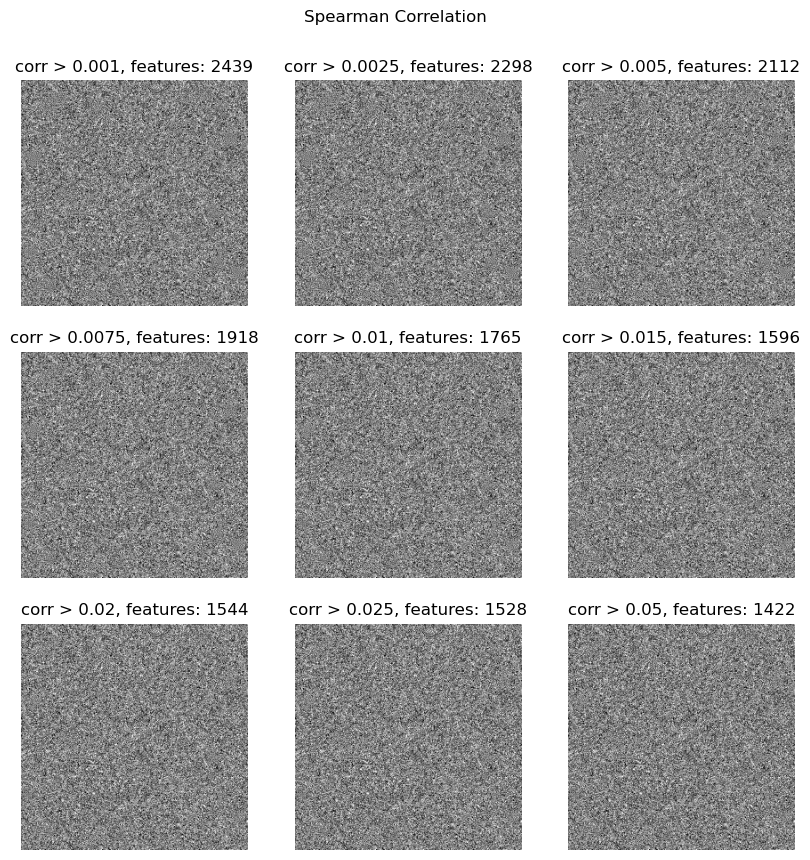

In [18]:
threshold = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.015, 0.02, 0.025, 0.05]

fig, ax = plt.subplots(3, 3, figsize=(10,10))
ax_ls = ax.flat
for i in range(9):
    t = threshold[i]
    idx = np.abs(spearman_corr) > t
    selected_X = remaining_X[:, idx]
    X_new = np.concatenate((preserved_X, selected_X), axis=1)
    lin = linear_model.LinearRegression(fit_intercept=True)
    lin.fit(X_new, y)
    y_pred = lin.predict(X_new)
    difference = science - y_pred.reshape(template.shape)
    ax_ls[i].imshow(interval(difference), cmap='gray', origin='lower')
    ax_ls[i].set_axis_off() 
    ax_ls[i].set_title(f'corr > {t}, features: {X_new.shape[1]}')
plt.suptitle('Spearman Correlation', y=0.95)

# correlation threshold, max number of bases

In [ ]:
# crop into pieces vs. high spatial degree of freedom
# if coef * base image has mean smaller than 5 sky, remove that feature